In [1]:
import torch ,  torchvision
from torchvision import transforms , datasets , models
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from matplotlib import image as img
import glob
import xml.etree.ElementTree as ET
from torch.utils.data import Dataset , DataLoader , SubsetRandomSampler as srs
import torchvision.transforms.functional as TF
from sklearn.preprocessing import MinMaxScaler

In [2]:
# https://drive.google.com/file/d/1la3oe-J3aioosw3cqe7T44kW7QxcgnjT/view?usp=sharing    trained model file
# https://drive.google.com/drive/folders/18XlIxPsVACa9lyrARwiLv8JnsfuTR2CM?usp=sharing    dataset files

In [8]:
root = "/content/drive/MyDrive/archive (4)"   #edit to where the folder is located

In [4]:
from google.colab import drive

In [5]:
drive.mount("/content/drive/")

Mounted at /content/drive/


In [9]:
path = root + "/images/Cars3.png"

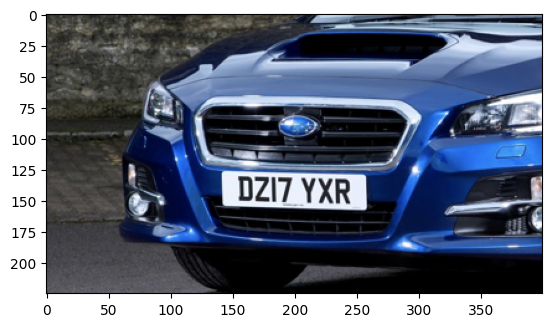

In [10]:
image = img.imread(path)
plt.imshow(image)
plt.show()

In [13]:
path = root + "/number-plate-detection/images/N100.jpeg"

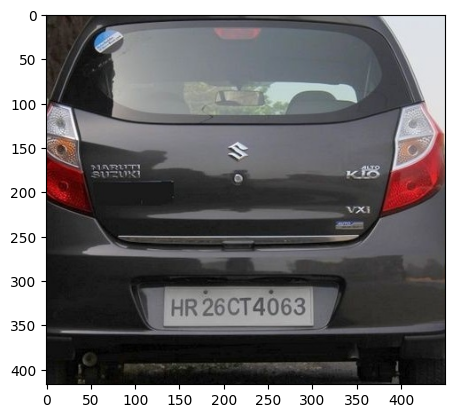

In [14]:
image = img.imread(path)
plt.imshow(image)
plt.show()

In [15]:
class cardataset1(Dataset):
    def __init__(self):
        self.annotation_list = sorted([file for file in glob.glob(root + "/annotations/*.xml")])



        self.image = [cv2.imread(file) for file in sorted(glob.glob(root + "/images/*.png") )]

        self.root = root
        self.transforms = transforms.Compose([transforms.ToTensor() , transforms.Resize((512 ,512)) , transforms.Normalize([0.5,0.5,0.5] , [0.5,0.5,0.5])
                                              ])

        self.trans = transforms.Compose([transforms.ToTensor()])

    def __len__(self):
        return len(self.image)

    def __getitem__(self ,index):
        img = self.image[index]
        img = self.transforms(img)

        target_size = (512, 512)


        image = self.image[index] //512
        image = self.trans(image)    # this line used in relation to get the corect bounding box after resizing image

        annotation = os.path.join(self.annotation_list[index])#(self.root , "annotations" , self.annotation_list[index])
        annotation  = ET.parse(annotation)

        box = []

        xml_root =  annotation .getroot()
        for obj in xml_root.iter("object"):
            xml_bbox = obj.find("bndbox")
            x_min =  float(xml_bbox.find("xmin").text)
            y_min =  float(xml_bbox.find("ymin").text)
            x_max =  float(xml_bbox.find("xmax").text)
            y_max =  float(xml_bbox.find("ymax").text)


            scale_factor_width  = target_size[1] / image.shape[2]  # width scale factor
            scale_factor_height = target_size[0] / image.shape[1]

            normalized_x_min = x_min * scale_factor_width
            normalized_y_min = y_min * scale_factor_height
            xx = x_max - x_min
            xxx = xx * scale_factor_width
            normalized_x_max = xxx + normalized_x_min
            yy = y_max - y_min
            yyy  = yy * scale_factor_height
            normalized_y_max = yyy  + normalized_y_min


            bbox = [normalized_x_min,
                   normalized_y_min,
                   normalized_x_max,
                   normalized_y_max,
                  ]

            #box.append(bbox)
            box = torch.tensor(bbox)
            label = torch.tensor([1])

        sample = [img , box , label]
        return sample



In [16]:
dataset1 = cardataset1()

In [17]:
class cardataset2(Dataset):
    def __init__(self):
        self.annotation_list = sorted([file for file in glob.glob(root + "/number-plate-detection/images/*.xml")])



        self.image = [cv2.imread(file) for file in  glob.glob(root + "/number-plate-detection/images/*.jpeg" )]


        self.transforms = transforms.Compose([transforms.ToTensor()  ,transforms.Normalize([0.5,0.5,0.5] , [0.7,0.7,0.5]), transforms.Resize((512,512)) ])


        self.trans = transforms.Compose([transforms.ToTensor()])

    def __len__(self):
        return len(self.image)

    def __getitem__(self ,index):
        img = self.image[index]
        img = self.transforms(img)

        target_size = (512,512)


        image = self.image[index]
        image = self.trans(image)    #this transform only transforms to tensor, this line used in relation to get the corect bounding box after resizing image

        annotation = os.path.join(self.annotation_list[index])#(self.root , "annotations" , self.annotation_list[index])
        annotation  = ET.parse(annotation)

        box = []

        xml_root =  annotation .getroot()
        for obj in xml_root.iter("object"):
            xml_bbox = obj.find("bndbox")
            x_min =  float(xml_bbox.find("xmin").text)
            y_min =  float(xml_bbox.find("ymin").text)
            x_max =  float(xml_bbox.find("xmax").text)
            y_max =  float(xml_bbox.find("ymax").text)


            scale_factor_width  = target_size[1] / image.shape[2]  # width scale factor
            scale_factor_height = target_size[0] / image.shape[1]

            normalized_x_min = x_min * scale_factor_width
            normalized_y_min = y_min * scale_factor_height
            xx = x_max - x_min
            xxx = xx * scale_factor_width
            normalized_x_max = xxx + normalized_x_min
            yy = y_max - y_min
            yyy  = yy * scale_factor_height
            normalized_y_max = yyy  + normalized_y_min


            bbox = [normalized_x_min,
                   normalized_y_min,
                   normalized_x_max,
                   normalized_y_max,
                  ]

            #box.append(bbox)
            box = torch.tensor(bbox)
            label = torch.tensor([1])

        sample = [img , box , label]
        return sample



In [18]:
dataset2 = cardataset2()

In [19]:
print(len(dataset1))
print(len(dataset2))

433
225


In [20]:
class combineddataset(Dataset):
  def __init__(self , dataset1 , dataset2):
    self.dataset1 = dataset1
    self.dataset2 = dataset2

    self.length = len(self.dataset1)+ len(self.dataset2)

  def __len__(self):
    return self.length

  def __getitem__(self , idx):
    if idx < len(self.dataset1):
      img , box, label = self.dataset1[idx]
      return img , box , label

    else:
      idx = idx - len(self.dataset1)
      img2 , box2 , label2 = self.dataset2[idx]
      return img2 , box2 , label2




In [21]:
dataset = combineddataset(dataset1 , dataset2)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


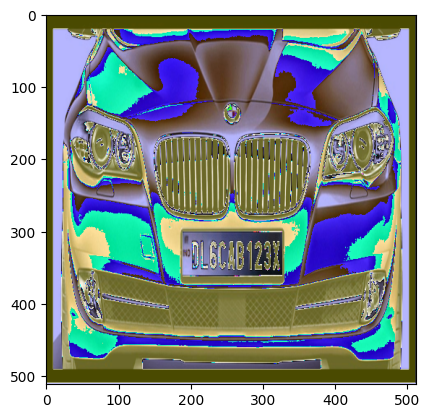

tensor([186.5956, 304.2743, 329.9556, 371.5657])

In [22]:
img , box , label = dataset[600]
imgpic = TF.to_pil_image(img)
plt.imshow(imgpic)

plt.show()
box

In [23]:
train_ratio = int(len(dataset) * 0.9)
val_ratio = int(len(dataset) * 0.05)
test_ratio = int(len(dataset) - (train_ratio + val_ratio))

In [19]:
train_ratio

592

In [20]:
train_ratio + val_ratio + test_ratio

658

In [24]:
torch.manual_seed(0)
train_set , val_set , test_set = torch.utils.data.random_split(dataset , [train_ratio , val_ratio , test_ratio])

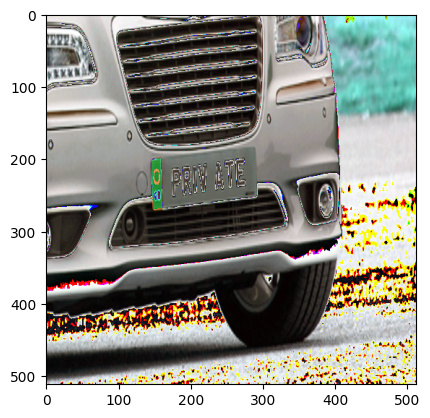

tensor([145.9200, 199.6800, 294.4000, 261.1200])

In [25]:
img , box , label = train_set[1]
img = TF.to_pil_image(img)
plt.imshow(img)
plt.show()
box

In [26]:
train_loader = DataLoader(train_set,batch_size= 1,
                          shuffle=True #, #num_workers =3
                          )

val_loader = DataLoader(val_set, batch_size= 1 ,shuffle=False ,
)


test_loader = DataLoader(test_set, batch_size= 1 ,shuffle=False ,
                        )

In [27]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

In [28]:
model = models.detection.fasterrcnn_resnet50_fpn(pretrained= True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 143MB/s]


In [29]:
ftrs = model.roi_heads.box_predictor.cls_score.in_features

In [30]:
model.roi_heads.box_predictor= FastRCNNPredictor(ftrs , 2)

In [31]:
def loss_fn(pred , target):
    #localization_loss = nn.MSELoss()
    loss = nn.MSELoss()(pred ,target)
    return loss


In [32]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [33]:
model = model.to(device)

In [34]:
model.load_state_dict(torch.load("/content/drive/MyDrive/numberplatemodel.pth"))

<All keys matched successfully>

In [ ]:
opt = torch.optim.Adam(model.parameters() , lr = 1e-6, weight_decay = 1e-3)

In [35]:
model = model.to(device)


In [ ]:
def train_line(model , img , box, label, opt ):
  model.train();
  device = "cuda"
  model = model.to(device)
  img = img.to(device)
  box = box.to(device)
  label = label.to(device)

  target =  [{"boxes" : box , "labels":labell}for labell in label ]
  loss = model(img, target)
  loss = sum(loss for loss in loss.values())
  #loss = loss_fn(pred , box)
  opt.zero_grad()
  loss.backward()
  opt.step()


In [ ]:
for num_epoch in range(50):
    for img_train , box_train , label_train in train_loader:
        model.train();
        img_train = img_train.to(device)
        box_train = box_train.to(device)
        label_train = label_train.to(device)

        #train_line(model , img_train , box_train , label_train ,  opt)      only initialize when training

    with torch.no_grad():
        loss_list = []
        print("============================Epoch: " , num_epoch)
        imgcount = 0
        for img_val , box_val , label_val in val_loader:
            model.eval();

            img_val = img_val.to(device)
            box_val = box_val.to(device)
            label_val = label_val.to(device)
            pred = model(img_val)
            box_pred =   pred[0]["boxes"]
            val_loss = loss_fn(box_pred, box_val)
            loss_list.append(val_loss)
            imgcount +=1
            print("===========image:" , {"img_count" : imgcount, "loss": val_loss})
        avg_loss = sum(loss_list) / len(loss_list)
        print("avg_val_loss: " , avg_loss)




            #print("score:" , score)

            #label = pred[0]["labels"]
            #print("labels", label)


In [182]:
#torch.save(model.state_dict() , "/content/drive/MyDrive/numberplatemodel.pth")

In [36]:
from matplotlib import image as im

In [41]:
imagetest = im.imread("/content/drive/MyDrive/Screenshot 2023-12-27 021928.jpg") #testing outsourced image

In [42]:
transform = transforms.Compose([transforms.ToTensor() , transforms.Resize((512 , 512))])

In [43]:
imagetest = transform(imagetest)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:152: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


In [44]:
img , target , label = test_set[32]
devicee = "cpu"
model = model.to(devicee)
model.eval()
prediction = model(imagetest.unsqueeze(0))   #edit imagetest to img to use image from testset
print(prediction)

[{'boxes': tensor([[304.9794, 307.6667, 391.8390, 324.2067],
        [511.7026, 343.3668, 511.9904, 355.2206],
        [  7.2720, 218.7264,  61.0144, 274.7008]], grad_fn=<StackBackward0>), 'labels': tensor([1, 1, 1]), 'scores': tensor([0.2665, 0.1975, 0.1097], grad_fn=<IndexBackward0>)}]


In [45]:
boxes= prediction[0]["boxes"]
scores = prediction[0]['scores']
#labels = prediction[0]['labels']

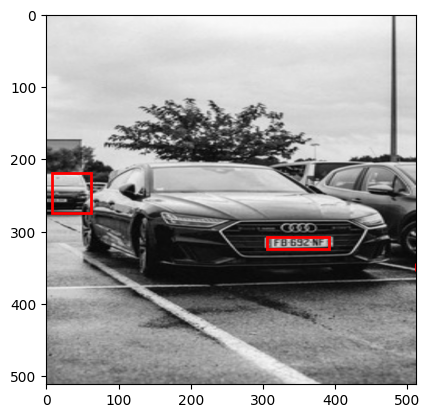

In [51]:
import matplotlib.pyplot as plt
from torchvision import transforms as T
transform = T.ToPILImage()
image =  transform(imagetest)
fig, ax = plt.subplots(1)
ax.imshow(image)
for box in boxes:
      xmin, ymin, xmax, ymax = box.tolist()
      rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor='red', linewidth=2)
      ax.add_patch(rect)

plt.imshow(image )

In [52]:
def calculate_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    intersection_area = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    boxA_area = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxB_area = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    union_area = float(boxA_area + boxB_area - intersection_area)

    iou = intersection_area / union_area
    return iou





In [53]:
f1_score_list = []
idx = 0
while idx < 31:
    img , bbox ,label  = test_set[idx]
    model.eval();
    pred = model(img.unsqueeze(0))
    idx+=1
    f1_score = calculate_iou(pred[0]["boxes"][:1].tolist()[0], bbox.tolist())
    f1_score_list.append(f1_score)

avg_score = sum(f1_score_list) / len(f1_score_list)
print(avg_score)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


0.7277543145414981
